In [223]:
import json as json
import pathlib as pl
from datetime import datetime
from os import path

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from numpy import array

gain = 3.
rcParams[ 'figure.figsize' ] = [ gain * 6.4, gain * 4.8 / 2 ]

In [224]:
for v in pl.Path( "./plots" ).glob( '*' ):
	if datetime.fromtimestamp( path.getctime( v ) ).date() >= datetime.fromisocalendar(2024, 37, 2).date():
		print( v, '\t\t', datetime.fromtimestamp( path.getctime( v ) ) )

plots\three_robots_chain_1725981792 		 2024-09-10 17:23:12.607056
plots\three_robots_chain_1725982395 		 2024-09-10 17:33:15.209467
plots\three_robots_chain_1725983462 		 2024-09-10 17:51:02.265681
plots\three_robots_chain_1725984151 		 2024-09-10 18:02:31.485258
plots\three_robots_chain_1725984674 		 2024-09-10 18:11:14.770524
plots\three_robots_chain_1725985581 		 2024-09-10 18:26:21.489613
plots\three_robots_chain_1725985667 		 2024-09-10 18:27:47.794658
plots\three_robots_chain_1725985778 		 2024-09-10 18:29:38.993805
plots\three_robots_chain_1725987609 		 2024-09-10 19:00:09.313886
plots\three_robots_chain_1725987889 		 2024-09-10 19:04:49.125741
plots\three_robots_chain_1725988336 		 2024-09-10 19:12:16.504329
plots\three_robots_chain_1725990018 		 2024-09-10 19:40:18.318134
plots\three_robots_chain_1725990436 		 2024-09-10 19:47:16.871415
plots\three_robots_chain_1725992307 		 2024-09-10 20:18:27.493109
plots\three_robots_chain_1725995232 		 2024-09-10 21:07:12.758302
plots\thre

In [225]:
folder = pl.Path( './plots/three_robots_chain_1726033948' )
data = pd.read_csv( f'{folder}/logs.txt', sep = '\t' )
with open( f'{folder}/config.json' ) as f:
	conf = json.load( f )

In [226]:
def disp( d: dict, prefix: str = '' ):
	for k, v in d.items():

		if isinstance( v, dict ):
			print( prefix + k + ':' )
			disp( v, prefix + '\t' )
			continue

		if isinstance( v, list ):
			if len( v ) > 0 and isinstance( v[ 0 ], dict ):
				print( prefix + k + ':' )
				disp( { str( i ): e for i, e in enumerate( v ) }, prefix + '\t' )
				continue

			l = array( v ).shape
			print( prefix + k + ':', v if sum( l ) < 10 else l )
			continue

		print( prefix + k + ':', v )


disp( conf )

model_dynamics: three_robots_chain
time_step: 0.01
kwargs:
	weight: [0.0, 0.0, 112.81500000000001]
	buoyancy: [0.0, 0.0, -120.0]
	center_of_mass: [0.0, 0.0, 0.0]
	center_of_volume: [0.0, 0.0, -0.02]
	inverted_inertial_matrix: (6, 6)
	hydrodynamic_matrix: (6, 6)
state: (36,)
actuation: (18,)
record: True
previous_states: (1, 36)
previous_actuations: (1, 18)
model: None
horizon: 25
target_trajectory: (4000, 1, 18)
objective: None
time_steps_per_actuation: 25
guess_from_last_solution: True
tolerance: 0.0001
max_iter: 1000
bounds: None
constraints:
	0:
		fun: constraint_f
		lb: (225,)
		ub: (225,)
		finite_diff_rel_step: None
		finite_diff_jac_sparsity: None
		jac: 2-point
		hess: None
		keep_feasible: False
result_shape: [1, 1, 18]
raw_result: None
result: (1, 1, 18)
pose_weight_matrix: (25, 18, 18)
actuation_derivative_weight_matrix: (1, 18, 18)
objective_weight: 0.0
final_weight: 10.0
predicted_trajectories: []
candidate_actuations: []
times: []
verbose: False


In [227]:
conf[ 'constraints' ][ 0 ][ 'ub' ][ :225 // 25 ]

[3.1, 3.1, 2.8, 2.8, 2.8, 2.8, 3.0, 3.0, 3.0]

In [228]:
data.tail( 10 )

,index,sim_time,step_time,success,C01,C12,D01,D12,H01,H12,state_r0,state_r1,state_r2,speed_r0,speed_r1,speed_r2,actuation_r0,actuation_r1,actuation_r2,Unnamed: 19
1990,1990,4197.803431,0.314091,True,0.941094,1.561901,1.195013,0.689532,0.745845,0.408612,"[1.9972750512579014, 0.0025355890533949998, -0...","[-0.35084202616998955, -0.6322931949172537, -0...","[1.493873668095354, -0.07140814905490077, -1.2...","[-0.021412369917735628, 0.017028226668893358, ...","[-0.27619393880958437, 0.3591954469469282, -0....","[-0.2595535005719836, 0.012818235602121223, -0...","[5.348111030656662, -2.2168030331843713, 7.240...","[-62.75967995166576, -16.138990663119564, 72.8...","[-56.36029272818109, 69.32802030566872, 73.350...",NaN
1991,1991,4198.179551,0.343581,True,0.938583,1.562554,1.194137,0.688725,0.742245,0.407769,"[1.9970867265858578, 0.0026979008924914497, -0...","[-0.3537901498472592, -0.6288298184355248, -0....","[1.4910900703286067, -0.0710011224131612, -1.2...","[-0.01622419644777097, 0.015463823912910579, 0...","[-0.3151089431139846, 0.33163547019478784, -0....","[-0.29703115045943657, 0.06725808562129093, -0...","[6.028038291522235, -1.9107978004068653, 7.230...","[-43.556628856499756, -33.83593465508676, 91.3...","[-41.97906827198099, 62.36099335532113, 93.255...",NaN
1992,1992,4198.518406,0.309909,True,0.935486,1.562702,1.193740,0.687958,0.738755,0.406821,"[1.9969533508294701, 0.0028459152380876855, -0...","[-0.3570451136333796, -0.6257197472632, -0.069...","[1.4879939807010523, -0.07007827898305204, -1....","[-0.010425407757937464, 0.014158362771601271, ...","[-0.33743310446007246, 0.2884956568884187, -0....","[-0.3221126404752849, 0.11591816251739982, -0....","[6.707965552387808, -1.6047925676293593, 7.219...","[-24.35357776133375, -51.532878647053955, 109....","[-27.597843815780895, 55.39396640497354, 113.1...",NaN
1993,1993,4199.045460,0.495767,True,0.931965,1.562380,1.193827,0.687231,0.735529,0.405782,"[1.996881037551956, 0.0029822320766968316, -0....","[-0.36044123806664685, -0.6231196289384349, -0...","[1.4847097003933, -0.06869791540725723, -1.291...","[-0.004014027937801976, 0.013113174145649829, ...","[-0.3431081649836145, 0.2296915404884068, -0.2...","[-0.33475446741867537, 0.1587671337723849, -0....","[7.387761907301574, -1.298817519655783, 7.2082...","[-5.1505266661677425, -69.22982263902115, 128....","[-13.216619359580797, 48.42693945462595, 133.0...",NaN
1994,1994,4201.387435,2.297388,True,0.928196,1.561665,1.194377,0.686564,0.732699,0.404700,"[1.9968758071650459, 0.003109438173715377, -0....","[-0.36381089138585876, -0.6211454724269134, -0...","[1.481363321864201, -0.06692333641212322, -1.2...","[0.002989322657202486, 0.012324495039878366, 0...","[-0.3318176354034486, 0.16343937249785317, -0....","[-0.33464289470799446, 0.19483945379722892, -0...","[8.041479473202118, -0.9987206034821112, 7.197...","[14.348734939535024, -77.40620729196986, 131.1...","[1.4746554174828326, 40.38866370163025, 150.35...",NaN
1995,1995,4202.791837,1.374953,True,0.924371,1.560694,1.195321,0.685980,0.730346,0.403648,"[1.9969435040703034, 0.003230088414634059, -0....","[-0.36699144146854334, -0.6198400850355843, -0...","[1.4780826343879567, -0.06484694655213644, -1....","[0.010570050848872924, 0.011789963148711792, 0...","[-0.30491950420504055, 0.0961449135027461, -0....","[-0.3217404923371989, 0.21926878651868703, -0....","[8.676120381032904, -0.702868900924376, 7.1866...","[32.22065453620688, -78.18957814157359, 122.80...","[16.157521595742406, 26.811356916753958, 149.1...",NaN
1996,1996,4204.814926,1.994027,True,0.920682,1.559606,1.196570,0.685490,0.728524,0.402686,"[1.9970896885881333, 0.0033466822541016157, -0...","[-0.3698299646564383, -0.619206898467634, -0.0...","[1.4749946915356753, -0.0625875110015766, -1.3...","[0.01868589864932898, 0.011501115678709942, 0....","[-0.26302334845937236, 0.029263381304175256, 0...","[-0.29621640580815867, 0.23164095335343132, -0...","[9.25998249532622, -0.4182379697397131, 7.1760...","[49.329875

In [229]:
from numpy.linalg import norm

state_r0 = data[ 'state_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r1 = data[ 'state_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
state_r2 = data[ 'state_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

speed_r0 = data[ 'speed_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r0[ 'l_norm' ] = norm( speed_r0[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r0[ 'a_norm' ] = norm( speed_r0[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r1 = data[ 'speed_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r1[ 'l_norm' ] = norm( speed_r1[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r1[ 'a_norm' ] = norm( speed_r1[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

speed_r2 = data[ 'speed_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
speed_r2[ 'l_norm' ] = norm( speed_r2[ [ 'x', 'y', 'z' ] ], axis = 1 )
speed_r2[ 'a_norm' ] = norm( speed_r2[ [ 'phi', 'theta', 'psi' ] ], axis = 1 )

actuation_r0 = data[ 'actuation_r0' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r1 = data[ 'actuation_r1' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)
actuation_r2 = data[ 'actuation_r2' ].apply(
		lambda x: pd.Series( [ float( v ) for v in x[ 1:-1 ].split( ',' ) ], [ 'x', 'y', 'z', 'phi', 'theta', 'psi' ] )
		)

n_frames = len( conf[ 'target_trajectory' ] )
traj = array( conf[ 'target_trajectory' ] )[ :n_frames // 2, :, : ]

# Errors

Text(0, 0.5, 'squared error [m]')

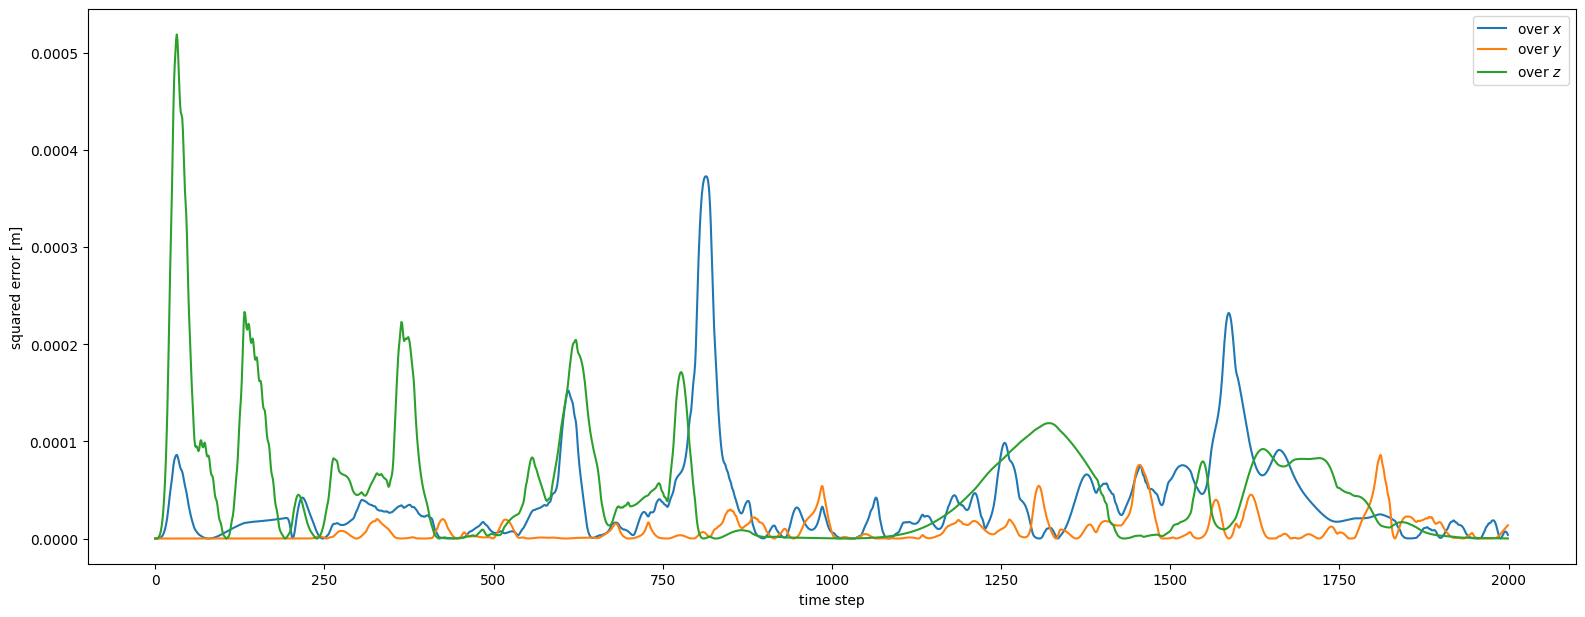

In [230]:
plt.plot( abs( traj[ :data.shape[ 0 ], 0, :3 ] - state_r0[ [ 'x', 'y', 'z' ] ] ) ** 2 )
plt.legend( [ 'over $x$', 'over $y$', 'over $z$' ] )
plt.xlabel( 'time step' )
plt.ylabel( 'squared error [m]' )

# Constraints

Text(0, 0.5, 'inter-robot distance [m]')

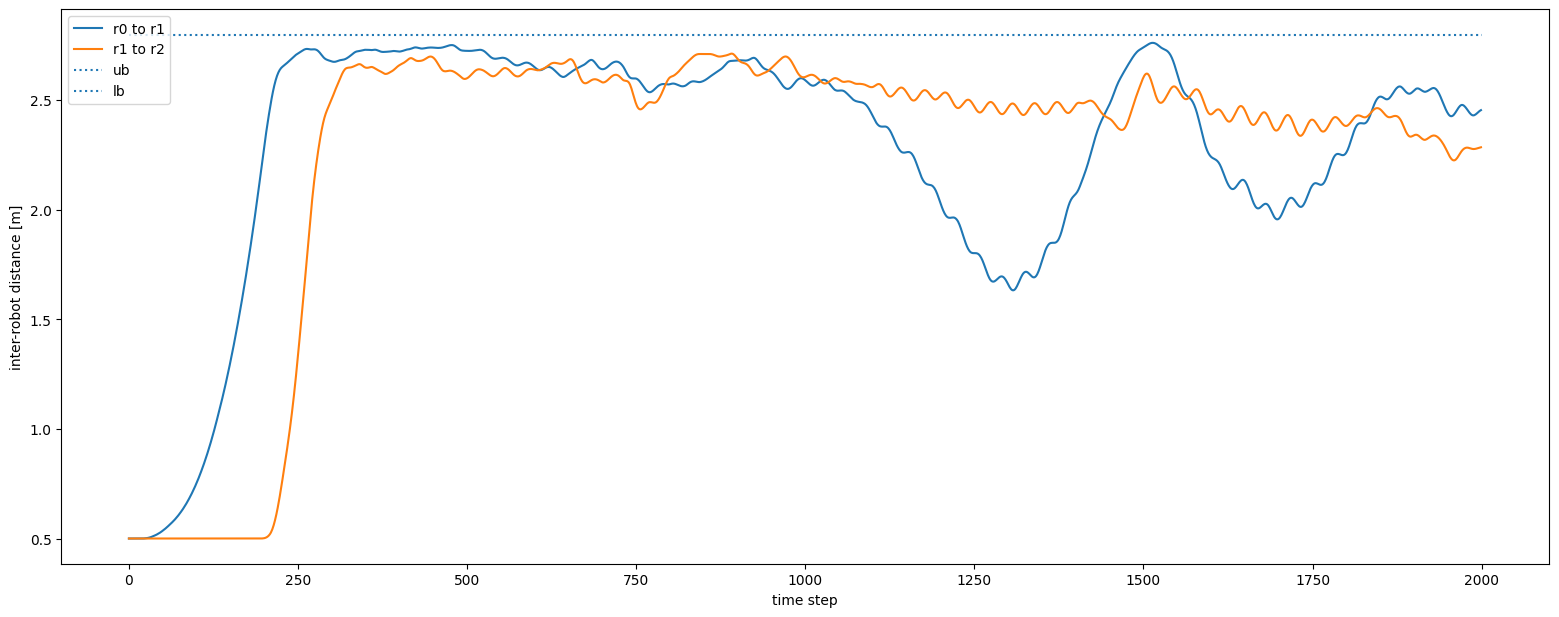

In [231]:
plt.plot( norm( state_r1[ [ 'x', 'y', 'z' ] ] - state_r0[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.plot( norm( state_r2[ [ 'x', 'y', 'z' ] ] - state_r1[ [ 'x', 'y', 'z' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 4 ], 0, n_frames // 2, linestyles = ':' )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'lb' ][ 4 ], 0, n_frames // 2, linestyles = ':' )
plt.legend( [ 'r0 to r1', 'r1 to r2', 'ub', 'lb' ] )
plt.xlabel( 'time step' )
plt.ylabel( 'inter-robot distance [m]' )

Text(0, 0.5, 'horizontal inter-robot distance [m]')

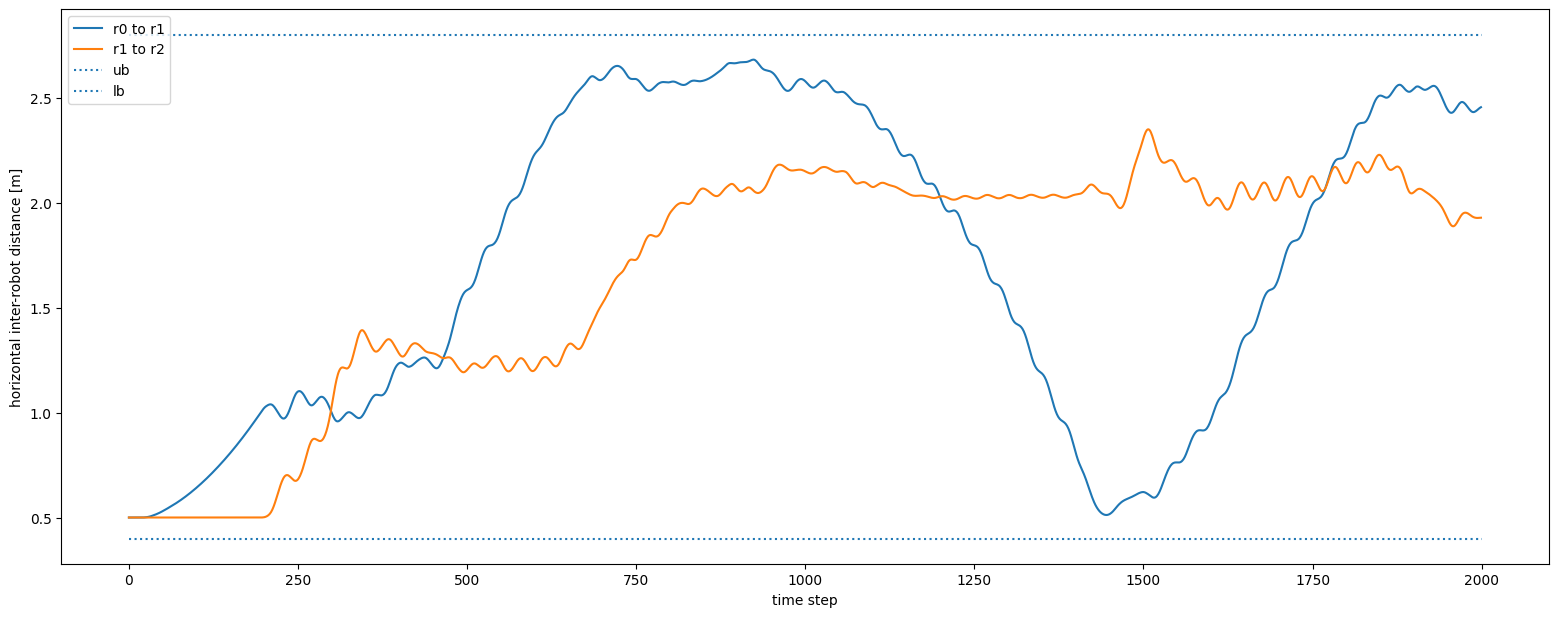

In [232]:
plt.plot( norm( state_r1[ [ 'x', 'y' ] ] - state_r0[ [ 'x', 'y' ] ], axis = 1 ) )
plt.plot( norm( state_r2[ [ 'x', 'y' ] ] - state_r1[ [ 'x', 'y' ] ], axis = 1 ) )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 2 ], 0, n_frames // 2, linestyles = ':' )
plt.hlines( conf[ 'constraints' ][ 0 ][ 'lb' ][ 2 ], 0, n_frames // 2, linestyles = ':' )
plt.legend( [ 'r0 to r1', 'r1 to r2', 'ub', 'lb' ] )
plt.xlabel( 'time step' )
plt.ylabel( 'horizontal inter-robot distance [m]' )

Text(0, 0.5, 'norm of speed [m/s]')

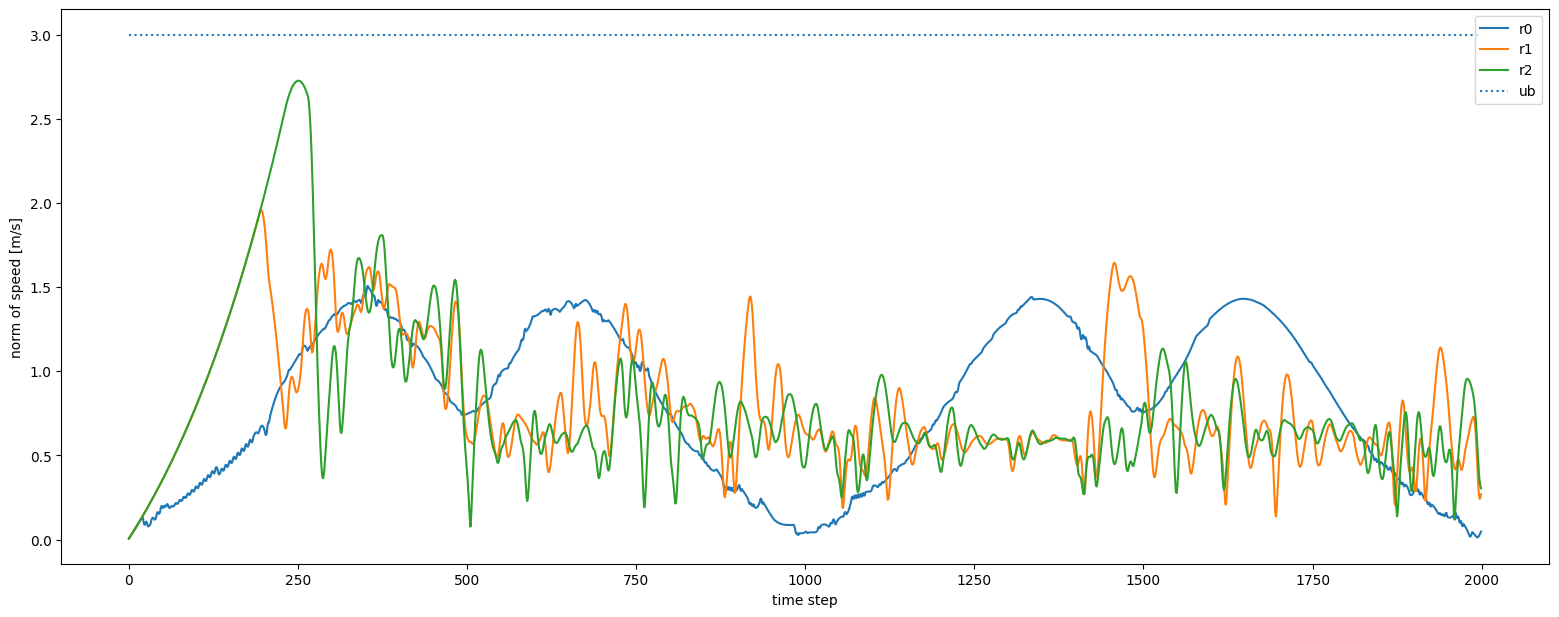

In [233]:
speed_r0['l_norm'].plot()
speed_r1['l_norm'].plot()
speed_r2['l_norm'].plot()
plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 6 ], 0, n_frames // 2, linestyles = ':' )
plt.legend(['r0', 'r1', 'r2', 'ub'])
plt.xlabel( 'time step' )
plt.ylabel( 'norm of speed [m/s]' )

# States

Text(0, 0.5, '$x$-axis [m]')

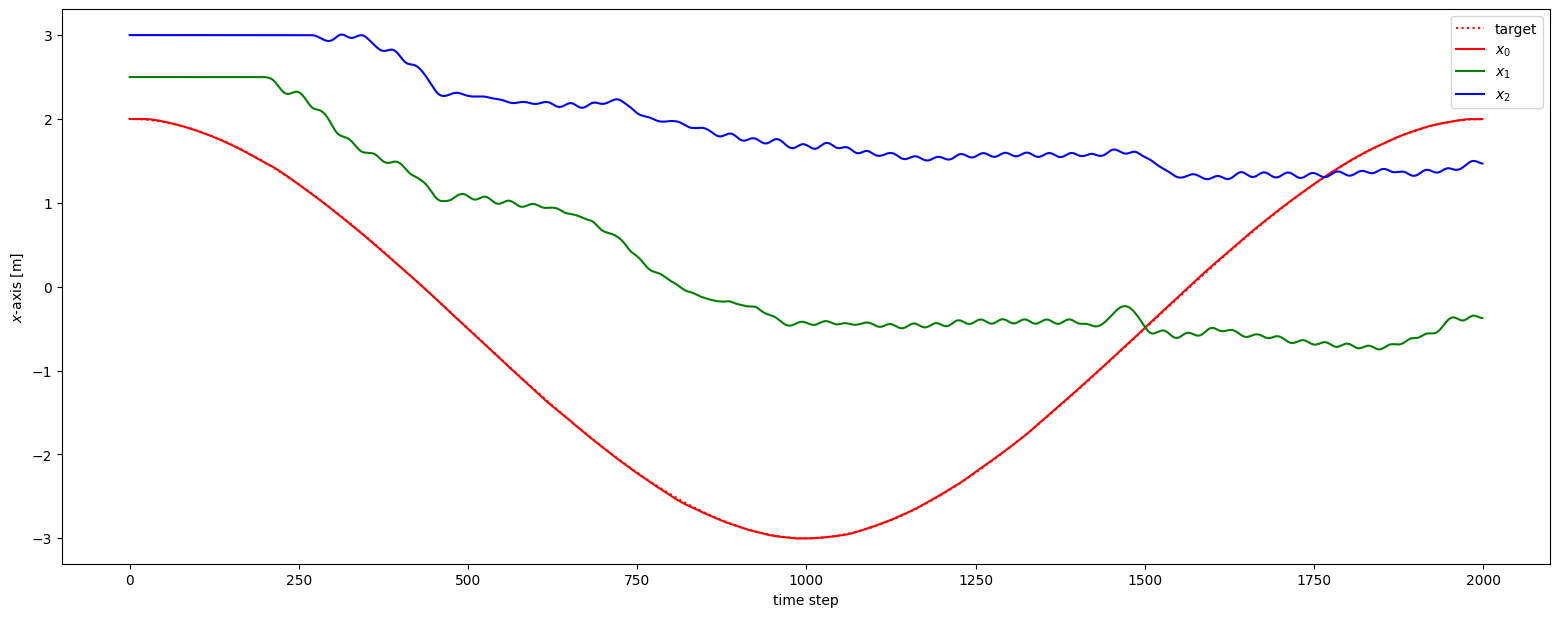

In [234]:
plt.plot( traj[ :, 0, 0 ], ':', color = 'r' )
plt.plot( state_r0[ 'x' ], 'r' )
plt.plot( state_r1[ 'x' ], 'g' )
plt.plot( state_r2[ 'x' ], 'b' )

plt.legend( [ 'target', '$x_0$', '$x_1$', '$x_2$' ] )
plt.xlabel( 'time step' )
plt.ylabel( '$x$-axis [m]' )

Text(0, 0.5, '$y$-axis [m]')

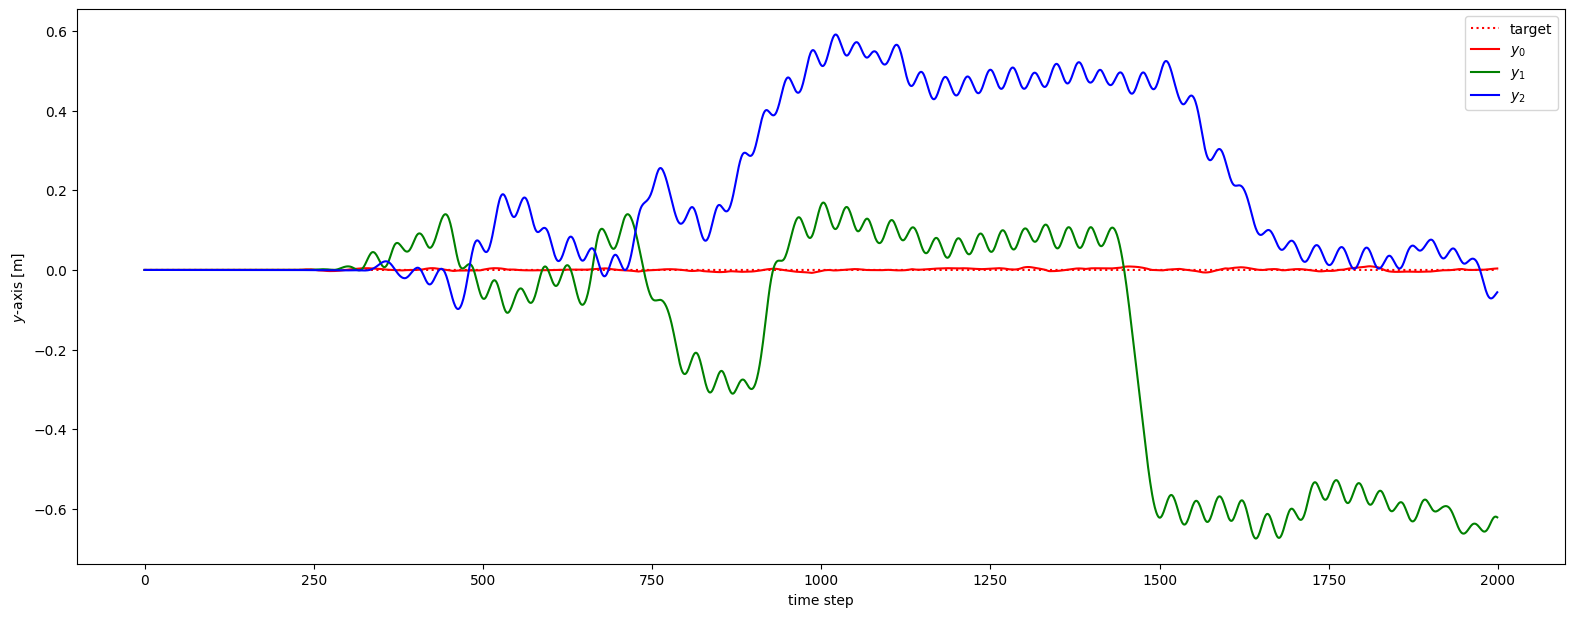

In [235]:
plt.plot( traj[ :, 0, 1 ], ':', color = 'r' )
plt.plot( state_r0[ 'y' ], 'r' )
plt.plot( state_r1[ 'y' ], 'g' )
plt.plot( state_r2[ 'y' ], 'b' )

plt.legend( [ 'target', '$y_0$', '$y_1$', '$y_2$' ] )
plt.xlabel( 'time step' )
plt.ylabel( '$y$-axis [m]' )

Text(0, 0.5, '$z$-axis [m]')

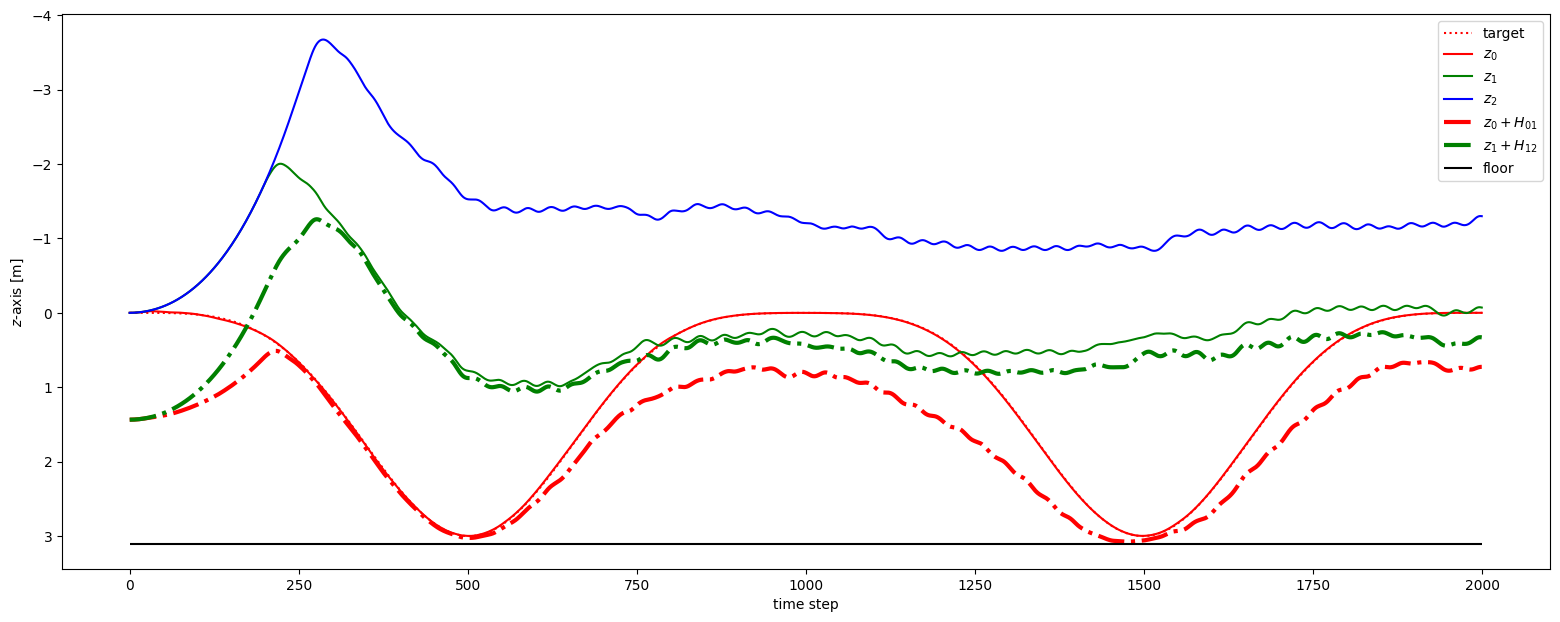

In [236]:
plt.plot( traj[ :, 0, 2 ], ':', color = 'r' )
plt.plot( state_r0[ 'z' ], 'r' )
plt.plot( state_r1[ 'z' ], 'g' )
plt.plot( state_r2[ 'z' ], 'b' )
plt.plot( data[ 'H01' ] + state_r0[ 'z' ], '-.', color = 'r', linewidth = 3 )
plt.plot( data[ 'H12' ] + state_r1[ 'z' ], '-.', color = 'g', linewidth = 3 )

plt.hlines( conf[ 'constraints' ][ 0 ][ 'ub' ][ 0 ], 0, n_frames // 2, 'k' )
plt.legend( [ 'target', '$z_0$', '$z_1$', '$z_2$', '$z_0 + H_{01}$', '$z_1 + H_{12}$', 'floor' ] )
plt.gca().invert_yaxis()
plt.xlabel( 'time step' )
plt.ylabel( '$z$-axis [m]' )

# Speeds

<Axes: >

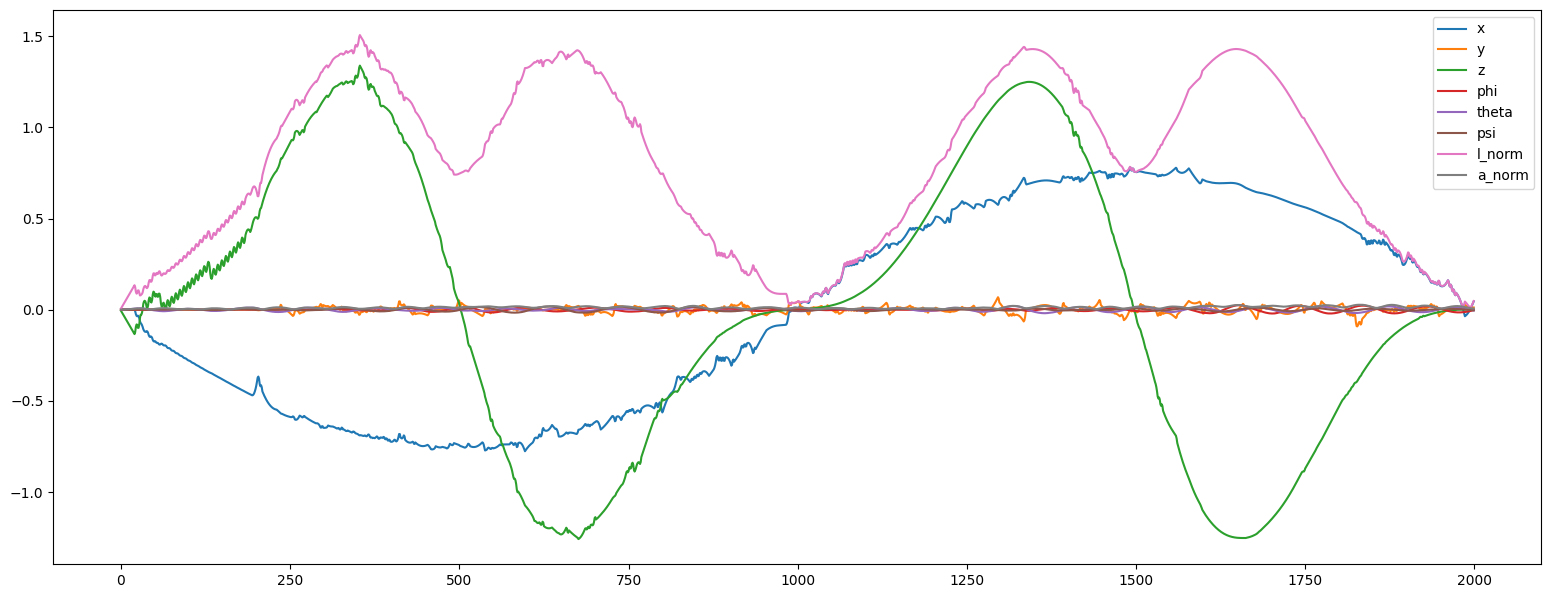

In [237]:
speed_r0.plot()

<Axes: >

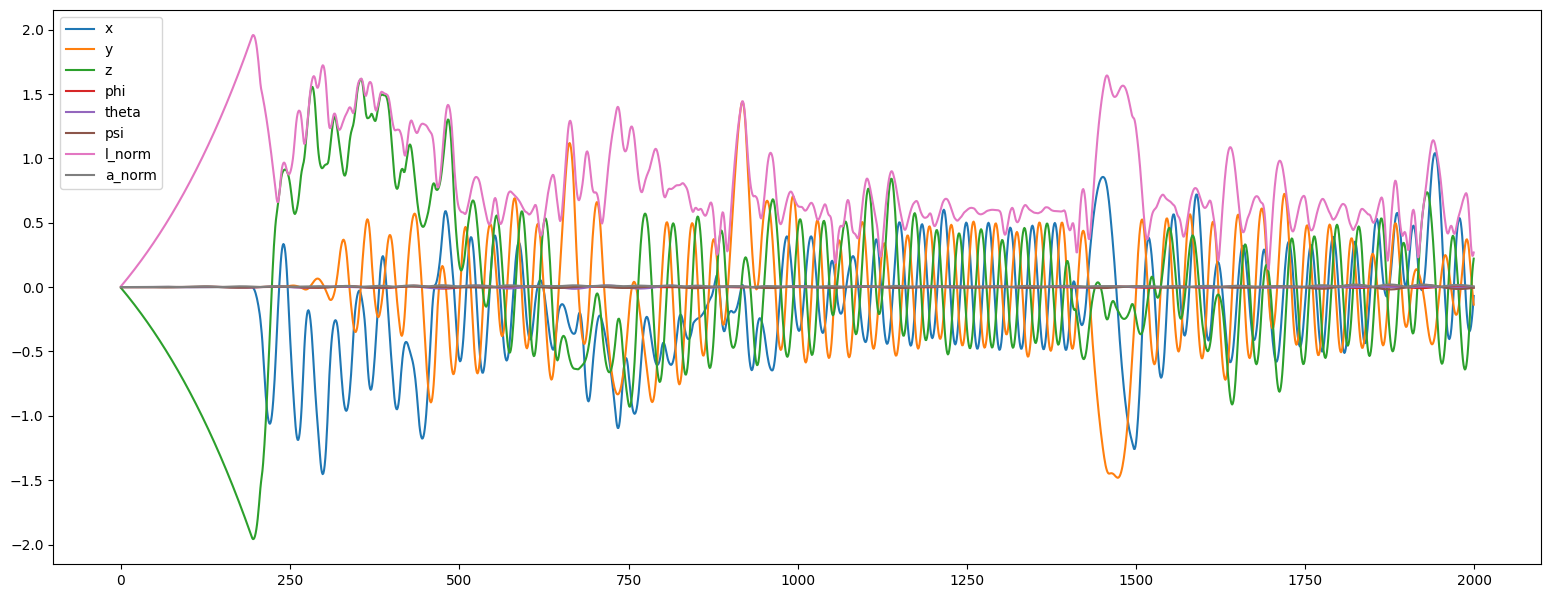

In [238]:
speed_r1.plot()

<Axes: >

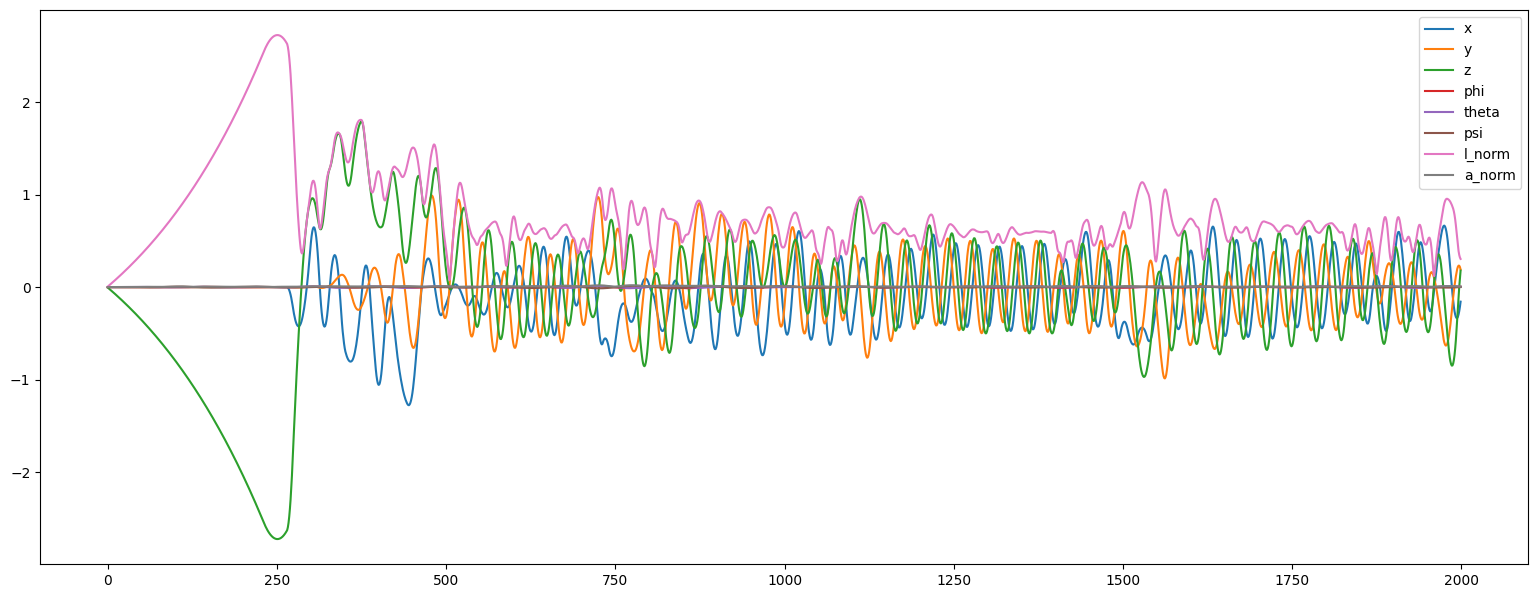

In [239]:
speed_r2.plot()

# Actuations

<Axes: >

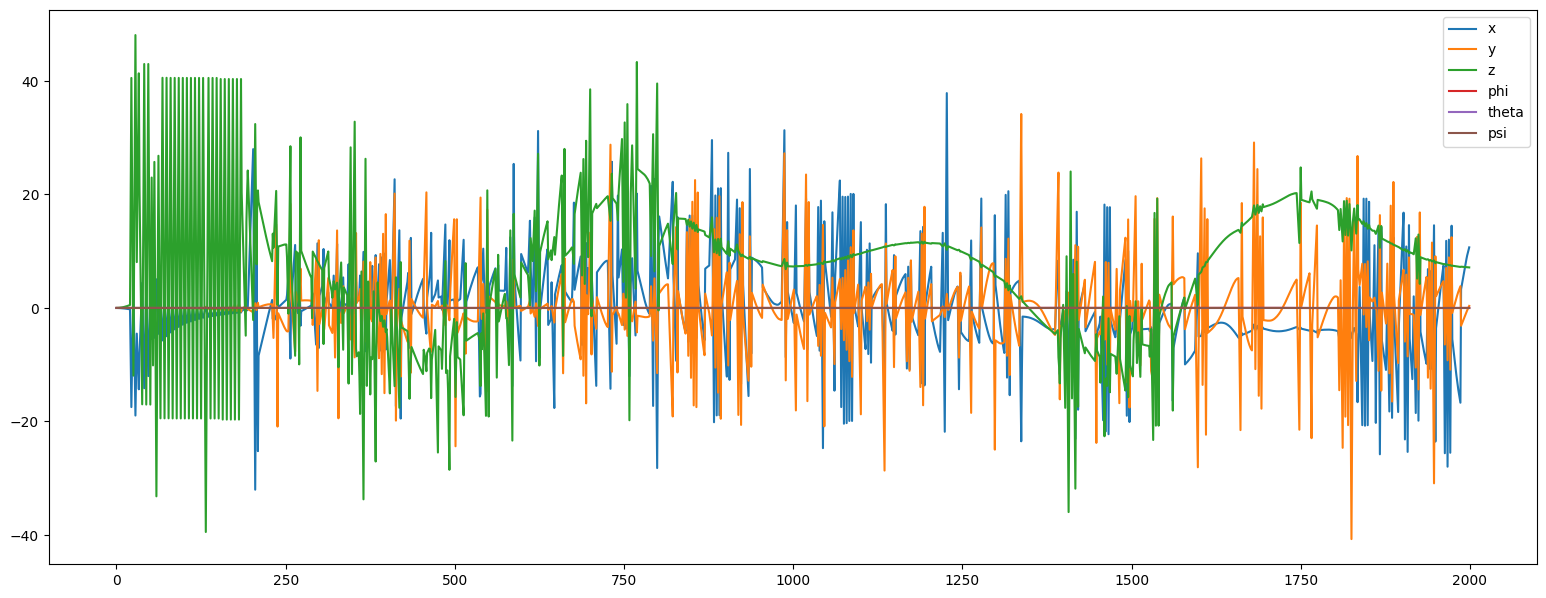

In [240]:
actuation_r0.plot()

<Axes: >

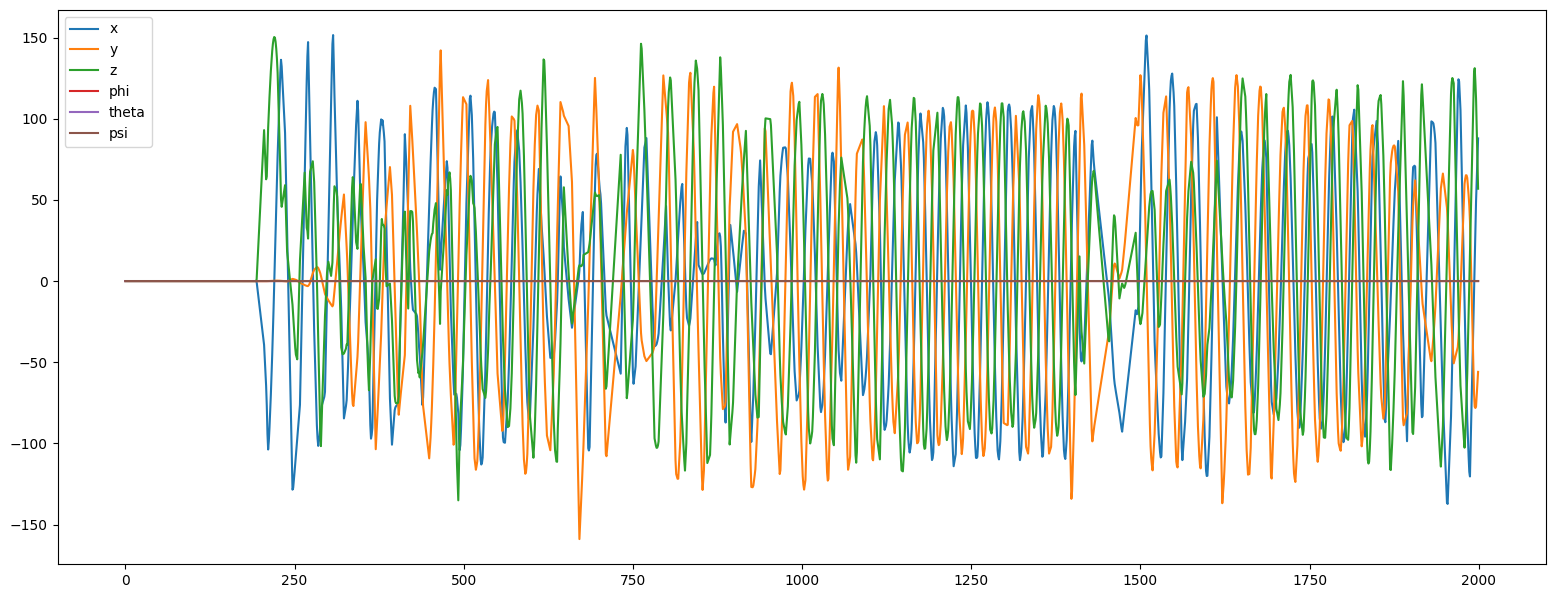

In [241]:
actuation_r1.plot()

<Axes: >

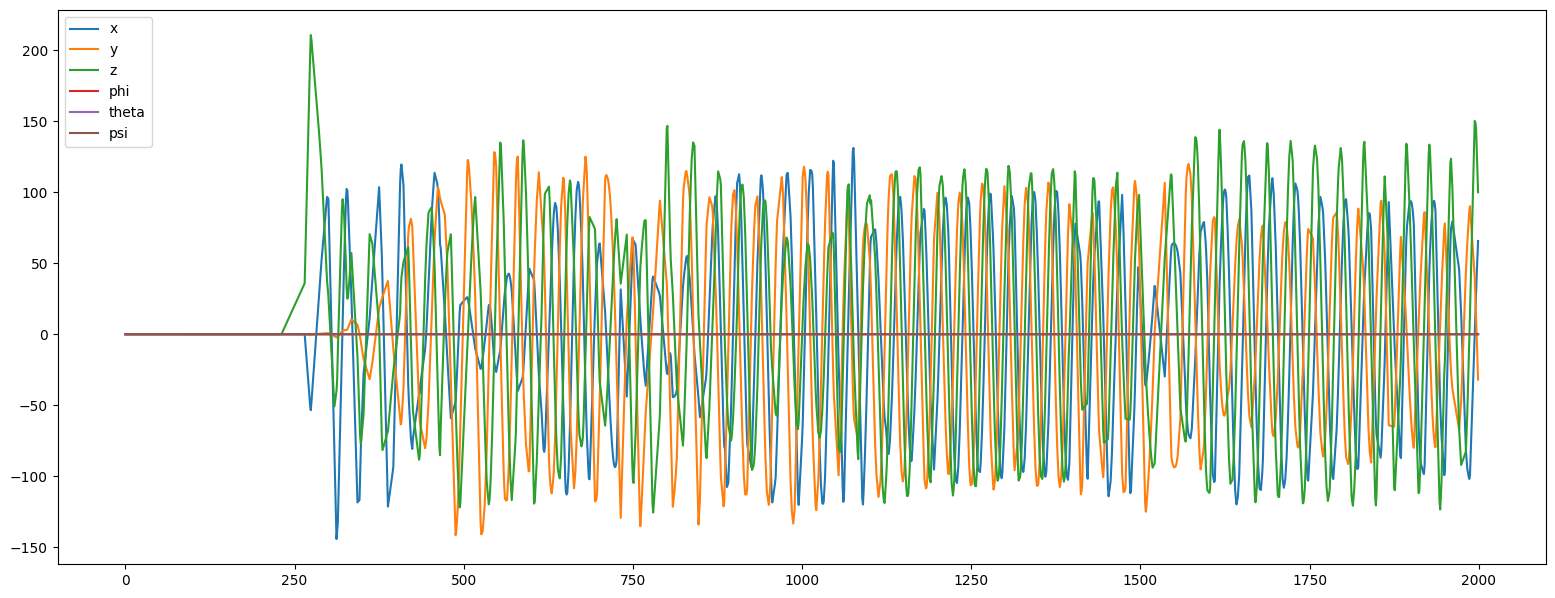

In [242]:
actuation_r2.plot()

# Time

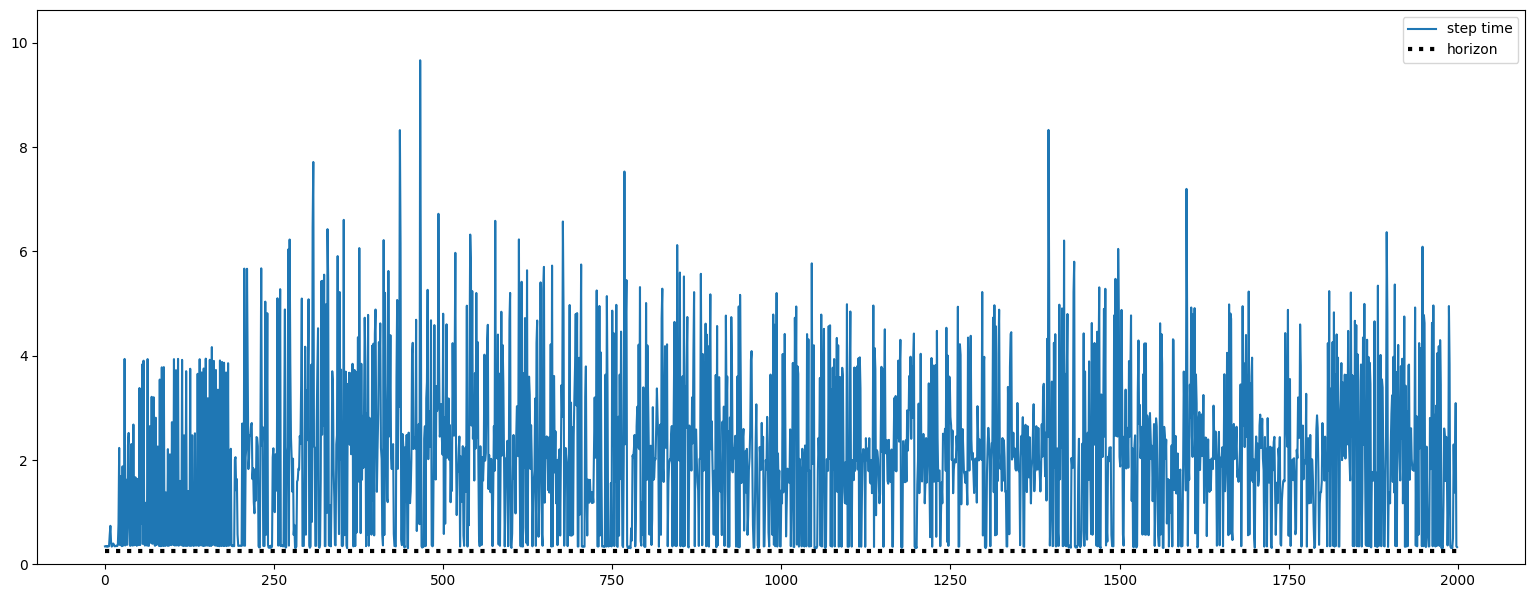

In [243]:
data[ 'step_time' ].plot()
plt.gca().set_ylim( 0, data.step_time.max() * 1.1 )
plt.hlines( conf[ 'time_step' ] * conf[ 'horizon' ], 0, data.shape[ 0 ], linestyles = ':', color = 'k', linewidth = 3 )
plt.legend( [ 'step time', 'horizon' ] )

In [244]:
for v in pl.Path( "./plots" ).glob( '*' ):
	if datetime.fromtimestamp( path.getctime( v ) ).date() >= datetime.fromisocalendar(2024, 37, 2).date():
		print( v, end = '\t' )
		print( datetime.fromtimestamp( path.getctime( v ) ), end = '\t' )
		record = pd.read_csv( f'{v}/logs.txt', sep = '\t' ).shape[ 0 ]
		with open( f'{v}/config.json' ) as f:
			conf = json.load( f )
		planned = array( conf[ 'target_trajectory' ] ).shape[ 0 ] // 2
		print( f'{record=}\t{planned=}\t{record == planned}' )

plots\three_robots_chain_1725981792	2024-09-10 17:23:12.607056	record=1000	planned=1000	True
plots\three_robots_chain_1725982395	2024-09-10 17:33:15.209467	record=1000	planned=1000	True
plots\three_robots_chain_1725983462	2024-09-10 17:51:02.265681	record=500	planned=500	True
plots\three_robots_chain_1725984151	2024-09-10 18:02:31.485258	record=200	planned=200	True
plots\three_robots_chain_1725984674	2024-09-10 18:11:14.770524	record=200	planned=200	True
plots\three_robots_chain_1725985581	2024-09-10 18:26:21.489613	record=500	planned=500	True
plots\three_robots_chain_1725985667	2024-09-10 18:27:47.794658	record=500	planned=500	True
plots\three_robots_chain_1725985778	2024-09-10 18:29:38.993805	record=500	planned=500	True
plots\three_robots_chain_1725987609	2024-09-10 19:00:09.313886	record=500	planned=500	True
plots\three_robots_chain_1725987889	2024-09-10 19:04:49.125741	record=1000	planned=1000	True
plots\three_robots_chain_1725988336	2024-09-10 19:12:16.504329	record=1000	planned=1